<center> <font size='6' font-weight='bold'> Projet Centrale </font> </center>  
<center> <i> Puzzle</i> </center>
<center> <i> Tony WU </i> </center>  
  
  
<img src=ressources/image_couverture.jpg>

# Préliminaires

## Objectifs

Le problème est le suivant. Une image a été découpée en morceaux rectangulaires **plus ou moins** de mêmes dimensions et ces morceaux ont ensuite été changé de place. L'objectif est de créer un algorithme qui prendrait le puzzle en entrée et renverrait l'image d'origine.  

**On peut décomposer le problème en plusieurs parties :** 
  
1) Récupérer les pièces de puzzle.
    
2) FORCE BRUTE: On va essayer toutes les permutations possibles de pièces, au nombre de $(n_{lignes} \times n_{colonnes})!$  
  - En fait, comme ce nombre est trop important, on va, lors de la construction de l'image finale, ne garder que les configurations qui présentent en faible gradient sur les bords. Pour définir la notion de faible gradient, on va se dire arbitrairement que si le gradient calculé est dans l'intervalle ±5% du gradient moyen calculé sur les bords de l'image d'origine, alors on rejette la solution actuelle et on passe à la suivante.

4) On crée une sorte de fonction coût, disons par exemple, pour une image en niveaux de gris :
\begin{equation}
J = \sum_{\text{bords des pièces}} (\vec{\nabla{u}} \circ \vec{n})^2
\end{equation}
    
Ainsi, l'objectif sera de trouver la configuration de puzzle qui minimise $J$.

## Modules

In [78]:
import numpy as np
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import time

from copy import deepcopy

from itertools import permutations

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import sys
sys.setrecursionlimit(1000)

import pdb

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from utils import *

# Découpage de l'image

**Rappel important**
Avec PIL, le système de coordonées pris est le suivant :
<img src=ressources/coords_system.png>

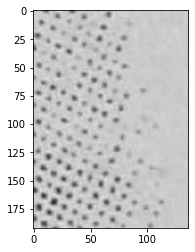

In [81]:
# Global variables, to change according to the given puzzle!
filename = 'img_test.jpg'
nb_lines = 9
nb_cols = 9

im_shuffled = read_img(filename)

cropped = split_img(im_shuffled, nb_lines, nb_cols, margin=(25,35))

plt.imshow(cropped[(0,0)])

In [82]:
save_cropped(cropped)

Images successfully saved.


# Calcul des gradients au bord

## Calcul du gradient

On essaie de garder les couleurs pour la configuration finale donc on somme le gradient pour chaque canal de couleur.

In [83]:
im1 = cropped[(0,0)]
im2 = cropped[(1,0)]

In [84]:
grad_x(im1, im2)

43446

In [85]:
grad_y(im1, im2)

54450

In [86]:
mean_grad(cropped, nb_lines, nb_cols)

3681387.0

## Assemblage du puzzle

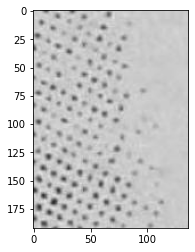

In [87]:
im_test = read_cropped_im(0, 0)
plt.imshow(im_test)

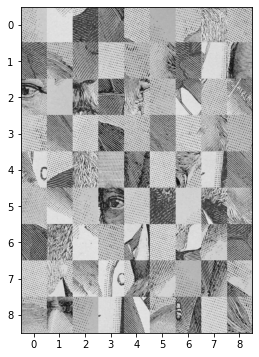

In [88]:
map_config = next(get_current_permutations(cropped))
original_img = config_to_img(map_config, nb_lines, nb_cols)

display_cropped(cropped, nb_lines, nb_cols, figsize=(5,6))

Nous allons essayer d'implémenter un algorithme fondé sur le backtracking.
Le score est choisi comme étant une moyenne du gradient selon x et selon y, mis au carré et divisé par le nombre de pièces.

L'objectif de la mise au carré est de pénaliser plus sévèrement les gros delta de gradient.

## Initialisation

**Préliminaire:** Pour que l'algorithme de backtracking soit efficace, il faut commencer d'un puzzle bien entamé pour pouvoir couper au plus tôt les branches non-intéressantes. On se propose alors de créer une fonction qui permet mouvoir soit-même les pièces pour le rendre en un temps restreint le plus homogène possible.

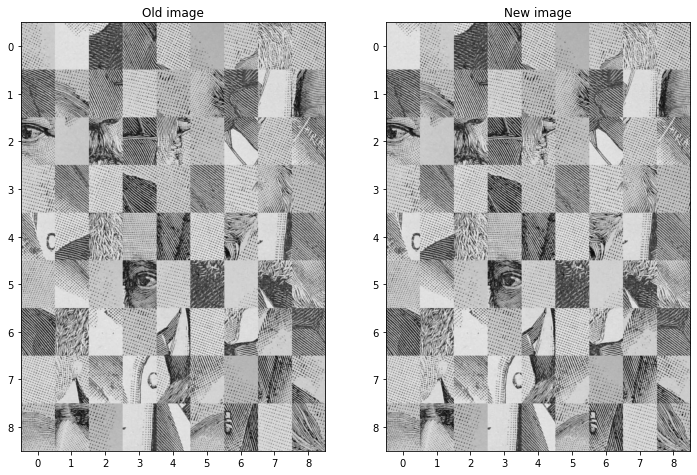

In [90]:
coords_1 = (0,0)
coords_2 = (1,0)

config_switcher_helper(cropped, nb_lines, nb_cols, coords_1, coords_2)

In [91]:
def launch_widget(cropped, nb_lines, nb_cols):
    # Global varibles
    global old_cropped, new_cropped, new_image
    old_cropped = deepcopy(cropped)
    new_cropped = deepcopy(cropped)
    original_image = cropped_to_img(cropped, nb_lines, nb_cols)
    new_image = None
    
    display_image(original_image, nb_lines, nb_cols, title='Original Image', figsize=(6,12))
    
    
    # --------- Defining widgets ---------
    x_old_widget = widgets.Dropdown(
        options=[str(i) for i in range(nb_lines)],
        value='0',
        description='x_old:',
        disabled=False,
    )

    y_old_widget = widgets.Dropdown(
        options=[str(i) for i in range(nb_lines)],
        value='0',
        description='y_old:',
        disabled=False,
    )

    x_new_widget = widgets.Dropdown(
        options=[str(i) for i in range(nb_lines)],
        value='0',
        description='x_new:',
        disabled=False,
    )

    y_new_widget = widgets.Dropdown(
        options=[str(i) for i in range(nb_lines)],
        value='0',
        description='y_new:',
        disabled=False,
    )

    list_coords_dropdown = [x_old_widget, y_old_widget, x_new_widget, y_new_widget]

    box_coords = widgets.HBox(children=list_coords_dropdown)
    
    apply_button = widgets.Button(
        description='Apply',
    )
    
    
    # --------- Defining buttons ---------
    @apply_button.on_click
    def apply_on_click(b=None):
        global old_cropped, new_cropped, new_image
        
        clear_output(wait=True)
        display(box_final)
        
        old_cropped = deepcopy(new_cropped)

        x_old = int(x_old_widget.value)
        y_old = int(y_old_widget.value)
        x_new = int(x_new_widget.value)
        y_new = int(y_new_widget.value)
        
        # The following coords are given with the index and not with the plt
        # coords system!
        coords_old = (x_old, y_old)
        coords_new = (x_new, y_new)
        
        print(f'coords_old={coords_old}, coords_new={coords_new}')
        
        
        plt.figure(figsize=(12, 10))

        
        
        # ---------- 1st sublot: Original Image ----------
        ax = plt.subplot(1, 2, 1)
        old_image = cropped_to_img(old_cropped, nb_lines, nb_cols)
        
        xticks_location = (old_image.width / nb_cols) / 2 + np.linspace(0, old_image.width, nb_cols+1)
        yticks_location = (old_image.height / nb_lines) / 2 + np.linspace(0, old_image.height, nb_lines+1)
        
        plt.imshow(old_image)
        plt.xticks(xticks_location, range(nb_cols))
        plt.yticks(yticks_location, range(nb_lines))
        plt.title('Old image')
        
        # Create a Rectangle patch
        # NB: 1st argument of patches.Rectangle gives the coords of the upper left
        # vertex of the rectangle.
        piece_height = old_image.height / nb_lines
        piece_width = old_image.width / nb_cols
        
        xy_rect_old = (x_old * piece_width, y_old * piece_height)
        xy_rect_new = (x_new * piece_width, y_new * piece_height)

        rect_old = patches.Rectangle(xy=xy_rect_old,
                                     width=piece_width,
                                     height=piece_height, 
                                     linewidth=3, 
                                     edgecolor='red', 
                                     facecolor='none')
        
        rect_new = patches.Rectangle(xy=xy_rect_new,
                                     width=piece_width,
                                     height=piece_height, 
                                     linewidth=3, 
                                     edgecolor='green', 
                                     facecolor='none')
        
        # Add the patches to the Axes
        ax.add_patch(rect_old)
        ax.add_patch(rect_new)
        
        
        
        # ---------- 2nd sublot: New Image ----------
        ax = plt.subplot(1, 2, 2)
        new_cropped = config_switcher(old_cropped, nb_lines, nb_cols, coords_1=coords_old, coords_2=coords_new)
        new_image = cropped_to_img(new_cropped, nb_lines, nb_cols)
        plt.imshow(new_image)
        plt.xticks(xticks_location, range(nb_cols))
        plt.yticks(yticks_location, range(nb_lines))
        plt.title('New image')
        
        return


    save_button = widgets.Button(
        description='Save',
    )

    @save_button.on_click
    def save_on_click(b=None):
        global new_image
        
        filename = time.strftime('%d-%m-%Y_%H%M%S', time.localtime()) + '.png'
        filepath = os.path.join('outputs', filename)
        
        try:
            new_image.save(filepath)
            print('File successfully saved.')
        except:
            print('Error saving file.')
        
        return
    
    
    # --------- Main ---------
    list_buttons = [apply_button, save_button]
    box_buttons = widgets.HBox(children=list_buttons)
    
    box_final = widgets.VBox(children=[box_coords, box_buttons])
    
    return box_final

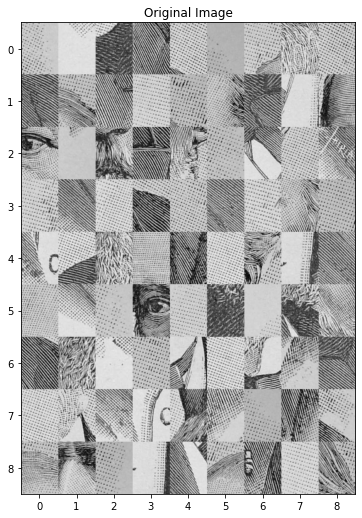

In [92]:
launch_widget(cropped, nb_lines, nb_cols)

## Résolution

In [ ]:
solve_backtracking(cropped, nb_lines, nb_cols)